In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
import pickle as pickle
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
#from pysynphot import observation
#from pysynphot import spectrum
import forwardmodel
import ciamod
import band
import TPmod
import cloud

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
# set up coarse pressure grid and fine pressure grid
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
print finePress.size
print coarsePress.size
print finePress

64
13
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.011872

[(0.2736809413618656, 0.30293120551537384, 0.34120151462119891), (0.48445224059474712, 0.71156067717230687, 0.91769069497791866), (1.1961662281671723, 1.782589514584159, 3.0539810335834474), (35.951655767668505, 92.987676756895482, 161.68954644660636), (1866.2276590395848, 1887.7409333445908, 1925.8177054208306)]

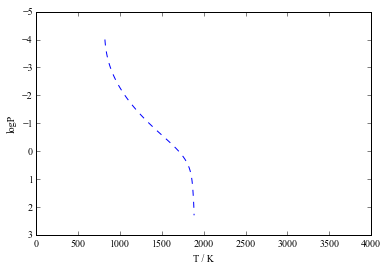

In [5]:
Tparams = np.array([(0.2736809413618656, 0.30293120551537384, 0.34120151462119891), (0.48445224059474712, 0.71156067717230687, 0.91769069497791866), (1.1961662281671723, 1.782589514584159, 3.0539810335834474), (35.951655767668505, 92.987676756895482, 161.68954644660636), (1866.2276590395848, 1887.7409333445908, 1925.8177054208306)])
Tparams[2,:] = np.log10(Tparams[2,:])
Tparams[3,:] = np.log10(Tparams[3,:])
temp = TPmod.set_prof(2,coarsePress,finePress,Tparams[:,1])
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.,4000.,3.0,-5.0])
#plt.plot(miketemp,np.log10(mikepress),'r-')
plt.plot(temp,np.log10(finePress),'b--')
plt.ylabel(r'logP')
plt.xlabel('T / K')

#

In [6]:
w1 = 0.7
w2 = 2.5

dist = 11.35
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds = 1
pcover = np.ones([npatches],dtype='f')
pcover = [1.0]
do_clouds = np.zeros([npatches],dtype='i')
do_clouds = [0]
cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum = [[99]]
cloudtype = np.array([npatches],dtype='i')
cloudtype = [[2]]

use_disort = 0 

# Set the profile type
proftype = 2

bits= np.array([(5.0225060735284526, 5.2071905701033137, 5.2882414217989506), (3.8810409944043399e-20, 4.0255440848136866e-20, 4.1710216532602051e-20), (0.0037438044311316355, 0.0045095531743837639, 0.0052347985565985942), (-31.218892232244485, -31.163579686043196, -31.094588555625002)])
logg = np.array(bits[0,1])
R2D2 = np.array(bits[1,1])
dlam = np.array(bits[2,1])

In [7]:
# Get the linelists
ngas = 10
gasnum = np.asfortranarray(np.array([1,4,7,8,9,10,11,12,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/cah_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/mgh_xsecs.pic","../Linelists/K_Mike_xsecs.pic","../Linelists/Na_Mike_xsecs.pic"]

In [8]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = interp1d(np.log10(inpress),np.log10(inlinelist[:,i,j]))
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [9]:
vmrlist = np.array([(-3.238885666839177, -3.0941061501768612, -2.9523289456700921), (-2.1749002429903657, -1.9968863427175205, -1.8249564880677571), (-8.4663926638126163, -7.314593346077209, -6.9170251600736483), (-8.5594327583521324, -8.2730769413576493, -8.0243398805307216), (-10.550982350042091, -7.6530080804397702, -4.891964723473146), (-7.2675383256046828, -7.0800925301827871, -6.8767851797518995), (-8.3087940236812177, -8.1000909312669975, -7.896163298122306), (-9.4083401517955565, -4.5953497993907195, -1.9812939733975066), (-8.0866181279624492, -4.7408973965252414, -4.445513336996834), (5.0314127035262368, 5.2086123554238126, 5.2881044552699983)])
alkratio = 16.2
VMR1 = np.full((npress,),vmrlist[0,1]) # water
vmr2 = np.full((npress,),vmrlist[1,1]) # CO
vmr3 = np.full((npress,),vmrlist[2,1])  
vmr4 = np.full((npress,),vmrlist[3,1]) 
vmr5 = np.full((npress,),vmrlist[4,1]) 
vmr6 = np.full((npress,),vmrlist[5,1])  
vmr7 = np.full((npress,),vmrlist[6,1])
vmr8 = np.full((npress,),vmrlist[7,1])
vmr9 = np.full((npress,),(np.log10((10.**vmrlist[8,1]) / (alkratio+1.))))# K
vmr10 = np.full((npress,),(np.log10((10.**vmrlist[8,1]) * (alkratio / (alkratio+1.)))))
#print VMR1.shape
logVMR = np.asfortranarray(np.reshape((VMR1,vmr2,vmr3,vmr4,vmr5,vmr6,vmr7,vmr8,vmr9,vmr10),(ngas,npress)),dtype='float64')
print logVMR.shape
press = finePress

(10, 64)


In [10]:

cloudnum = np.asfortranarray(np.array([99]),dtype='i')
cloudrad = np.asfortranarray(np.full((1,npress,1),5.0),dtype='float64')
cloudsig = np.asfortranarray(np.full((1,npress,1),1.0),dtype='float64')
cloudprof = np.asfortranarray(np.full((1,npress,1),-23.0),dtype='float64')
pcover = np.asfortranarray(pcover,dtype='float32')
do_clouds = np.asfortranarray(do_clouds,dtype='i')

In [11]:
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')
print cia.shape
print ciatemps.shape
print cia.dtype
print forwardmodel.marv.__doc__

(4, 198, 10286)
(198,)
float32
outspec = marv(temp,logg,r2d2,ingasnum,logvmr,pcover,do_clouds,incloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,inpress,inwavenum,inlinelist,cia,ciatemps,use_disort)

Wrapper for ``marv``.

Parameters
----------
temp : input rank-1 array('d') with bounds (64)
logg : input float
r2d2 : input float
ingasnum : in/output rank-1 array('i') with bounds (f2py_ingasnum_d0)
logvmr : input rank-2 array('d') with bounds (f2py_logvmr_d0,f2py_logvmr_d1)
pcover : in/output rank-1 array('f') with bounds (f2py_pcover_d0)
do_clouds : in/output rank-1 array('i') with bounds (f2py_do_clouds_d0)
incloudnum : in/output rank-2 array('i') with bounds (f2py_incloudnum_d0,f2py_incloudnum_d1)
cloudrad : in/output rank-3 array('d') with bounds (f2py_cloudrad_d0,f2py_cloudrad_d1,f2py_cloudrad_d2)
cloudsig : in/output rank-3 array('d') with bounds (f2py_cloudsig_d0,f2py_cloudsig_d1,f2py_cloudsig_d2)
cloudprof : in/output rank-3 array('d') with bounds (f2py_cloudprof_d0,f2py_cloudpr

In [12]:
tmpoutspec = forwardmodel.marv(temp,logg,R2D2,gasnum,logVMR,pcover,do_clouds,cloudnum,cloudrad,cloudsig,cloudprof,inlinetemps,press,inwavenum,linelist,cia,ciatemps,use_disort)
outspec = np.zeros((2,nwave),dtype='d')
outspec[:,:] = tmpoutspec[:,:nwave]

In [13]:
#np.savetxt('Ray_TESTspectrum.dat', np.c_[outspec[0],outspec[1]])

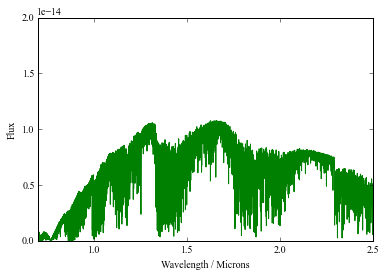

In [14]:
#B = np.empty(nwave,dtype='d') 
#B = 3.14159274*((2.*6.62606957e-34*(2.99792458e8**2.)) / ((outspec[0,:]*1.e-6)**5.)) / ((np.exp((6.62606957e-34*2.99792458e8)/(outspec[0,:]*1e-6*1.3806488e-23*1000.)))-1.) * 1.e-6
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 2.5,0.0,2e-14])
#oldspec = np.loadtxt("8gas_TESTspectrum.dat", unpack=True)
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.plot(oldspec[0,:],oldspec[1,:],'r-')
plt.plot(outspec[0,:],outspec[1,:],'g-')
#plt.plot(outspec_c[0,:],outspec_c[1,:],'r-')

#plt.plot(outspec[0,:],(1.+ ((outspec[1,:]- oldspec[1,:])/outspec[1,:]))*1e5,'g-')

#plt.plot(mikespec[0,:],outspec[1,:] / (mikespec[1,:]/1e6),'r-')
#plt.plot(mikespec[0,:],((mikespec[1,:] / 1e6) / outspec[1,:]), 'r-')
#plt.plot(outspec[0,:],np.full(nwave,1.0),'b--')

#plt.plot(outspec[0,:],6.666*outspec[1,:],'b-')
plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig('testspec.pdf',format='pdf', dpi=720)

In [15]:
wlen = outspec.shape[1]
wint = outspec[0,0] - outspec[0,wlen-1]
disp = wint / wlen
fwhm = 0.005
gwidth = int(round(fwhm / disp))
print outspec.shape

(2, 10286)


In [16]:
gauss = Gaussian1DKernel(gwidth)
cspec = convolve(outspec[1,:],gauss,boundary='extend')
spec = np.array([outspec[0,::-1],cspec[::-1]])

In [17]:
obspec = np.loadtxt("2M2224_mkoJcalib.dat",unpack=True)
pltspec = np.ones([obspec.shape[1]])
wavenew = obspec[0,:]
wfit = sp.interpolate.splrep(spec[0,:],spec[1,:],s=0)
pltspec = sp.interpolate.splev(wavenew,wfit,der=0)
#np.savetxt('2m2224_Ray_off_test.dat', np.c_[spec[0],spec[1]])

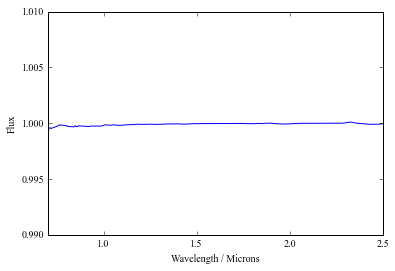

In [18]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 2.5, 0.99,1.01])
bspec = np.loadtxt("2m2224_FIT_spectrum.dat", unpack="true")
#plt.plot(wavenew,pltspec,'r-')
plt.plot(bspec[0,:],pltspec[:] / bspec[1,:],'b-')
#plt.plot(spec[0,:],mspec[1,:] / spec[1,:],'g-')
plt.ylabel( 'Flux')
plt.xlabel('Wavelength / Microns')


In [ ]:
print spec

In [ ]:
print 10000.  /rawwavenum[rawwavenum.size-1]